<a href="https://colab.research.google.com/github/VictorFrancheto/Complex_Network/blob/main/__Notebook_Synchronization__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Synchronization in Complex Networks**


---





Victor Hugo F. Francheto

University of São Paulo, SP

victor.francheto@usp.br



Bruno B. Pereira

University of São Paulo, SP

bruno.pereira@usp.br


---


**Chosen Topic:**

### **5 - How is synchronization influenced by network topology?**

See: [https://github.com/fabridamicelli/kuramoto](https://github.com/fabridamicelli/kuramoto)

Refer to the article:
[Synchronization in complex networks](https://www.sciencedirect.com/science/article/pii/S0370157308003384)

Generate networks using different models and observe how synchronization changes according to the model. A graph of the order parameter ($r$) as a function of coupling $\lambda$ can be plotted.

Analyze how community structure affects synchronization by adjusting the parameter $\mu$ in the LFR model that generates modular networks.

### Importing libraries

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.integrate import *
from scipy.special import zeta
from numpy import linalg as LA
from pylab import *
import math

## Introduction to the Kuramoto Model

The Kuramoto model, proposed by physicist Yoshiki Kuramoto in the 1970s, is a mathematical model used to describe the synchronization of coupled oscillator systems. This model is widely applied in various fields such as physics, biology, engineering, and even social sciences, due to its ability to capture the essence of synchronization phenomena in complex systems.

### Model Description

The Kuramoto model for complex networks considers a set of $N$ oscillators, each with a phase $\theta_i(t)$ and a natural frequency $\omega$. The dynamics of each oscillator are described by the following differential equationuation:

$$
\frac{d\theta_i}{dt} = \omega_i + \lambda \sum_{j=1}^{N} A_{ij} \sin(\theta_j - \theta_i),
$$

where:

- $\theta_i(t)$ is the phase of the $i$-th oscillator at time $t$;
- $\omega_i$ is the natural frequency of the $i$-th oscillator;
- $\lambda$ is the coupling strength between the oscillators;
- $A_{ij}$ is the adjacency matrix of the network, where $A_{ij} = 1$ if there is a connection between oscillator $i$ and oscillator $j$, and $A_{ij} = 0$ otherwise.

### Synchronization

The interest in the Kuramoto model lies in its ability to describe how independent oscillators, when coupled, can synchronize their phases. In particular, depending on the value of the coupling strength $\lambda$, the system can transition from a disordered state (where the oscillators have independent phases) to a synchronized state (where all oscillators oscillate in unison).

### Network Topologies

To study synchronization in different network topologies, the Kuramoto model can be adapted by considering different forms of connectivity among the oscillators. Some common topologies include:

- **Complete Network:** Each oscillator is couple; to every other oscillator.
- **Ring Network:** Each oscillator is coupled only to its;nearest neighbors in a ring.
- **Complex Networks:** These include topologies such as small-world networks and scale-free networks, which capture the structure of many real-world networks, such as neural and social networks.

By exploring the synchronization behavior of the Kuramoto model in different topologies, it is possible to gain insights into how network structure influences the emergence of synchronization, which has important implications for understanding complex dynamic systems in various disciplines.
ystems in various disciplines.
stems in various disciplines.
stems in various disciplines.


### Implementing the Kuramoto model

To have greater flexibility in choosing the parameters for the Kuramoto model, we will implement the model manually instead of using a pre-existing library.

In [ ]:
# First-order Kuramoto model
def F(Y, t, G, W, lbd):
    #global W, N, lbd, G
    N = len(G.nodes())
    F = zeros((N),float)
    S = zeros((N),float)
    dg = G.degree()
    for i in range(0, N):
        for j in G.neighbors(i):
            S[i] = S[i] + sin(Y[j]-Y[i])
    ld = lbd
    F = W + ld*S #traditional Kuramoto
    return F

### Function to extract synchronization parameters

In [ ]:
def calculate_sync(G):
    # Removing network direction
    G = G.to_undirected()

    # Converting node labels to integers
    G = nx.convert_node_labels_to_integers(G, first_label=0)

    # Number of nodes
    N = len(G)

    # Degree calculation
    vk = dict(G.degree())
    vk = list(vk.values())
    av_k = mean(vk)  # Average degree

    # Creating adjacency matrix
    A = nx.adjacency_matrix(G)
    A = A.todense()  # Adjusting the matrix

    # Calculating eigenvalues
    eig, vectors = LA.eig(A)
    lambda_max = eig.max()  # Getting the largest eigenvalue

    # Initial phases
    w0 = np.pi
    y0 = np.random.normal(0, w0, size=N)

    # Natural frequency
    W = np.random.uniform(-w0, w0, size=N)

    # Critical coupling
    hist, bin_edges = np.histogram(W, density=True)
    g0 = max(hist)
    lambda_c = 2 / (np.pi * lambda_max * g0)

    # Integration time
    t0 = 0.0  # Start
    h = 0.02  # Increment
    Np = 3000  # Number of interactions
    tStop = int(Np * h)  # Integration end
    t = np.linspace(t0, tStop, Np)

    # Synchronization process
    vlbd = []  # vector that stores the coupling strength
    aux = 0
    Ns = 1  # Number of Simulations
    vlbd = np.arange(0, 10 * lambda_c, lambda_c / 5)  # variation of the coupling strength
    mvr = np.zeros(shape=shape(vlbd))
    for s in np.arange(0, Ns):
        vr = []  # vector that stores the order parameter
        for lbd in vlbd:
            y = odeint(F, y0, t, (G, W, lbd))
            y = np.array(y)
            y = y[range(len(y) - round(0.9 * len(y)), len(y)), :]
            y = y.mean(0)
            psi = mean(y)
            r = abs((1.0 / N) * sum(np.exp(1j * y)))
            vr.append(r)
            aux = aux + 1
            y0 = y  # adiabatic increase
        mvr = mvr + vr
    mvr = mvr / Ns
    vlbd = np.array(vlbd, dtype=float)
    if len(mvr) != len(vlbd):
        min_length = min(len(vlbd), len(mvr))
        vlbd = vlbd[:min_length]
        mvr = mvr[:min_length]

    return vlbd, mvr, lambda_c

Let's generate some networks for later synchronization analysis.

### Creating networks with and without community structures

### Function Descriptions

- **network_with_communities:** Creates a network with defined community structure using the random partition model.
- **network_with_LFR_communities:** Generates a network with communities based on the LFR benchmark graph.
- **erdos_renyi_network:** Creates an Erdős-Rényi network with given parameters.
- **small_world_network:** Generates a Small World network using the Watts-Strogatz model.
- **barabasi_albert_network:** Creates a scale-free network using the Barabási-Albert model.
- **plot_network:** Plots the given network, removing self-loops and focusing on the largest connected component.


In [ ]:
# Random network with community structure
def network_with_communities(partition_sizes, p_in, p_out, seed=None):
    # Define sizes of partitions (communities)
    partition_sizes = partition_sizes

    # Define connection probabilities
    p_in = p_in  # Probability of edge within the same community
    p_out = p_out  # Probability of edge between different communities

    # Generate the random partitioned graph
    G = nx.random_partition_graph(partition_sizes, p_in, p_out, seed=seed)
    return G

# Generates a stochastic block model graph
def stochastic_block_model_graph(partition_sizes, p_in, p_out, seed=None):
    """
    Parameters:
    - partition_sizes: List of sizes of partitions (communities).
    - p_in: Probability of edge within the same community.
    - p_out: Probability of edge between different communities.
    - seed: Seed for random number generator (default is None).

    Returns:
    - G: A NetworkX graph generated using the stochastic block model.
    """

    # Define the probability matrix p
    p = [
        [p_in, p_out, p_out],
        [p_out, p_in, p_out],
        [p_out, p_out, p_in]
        ]

    # Generate stochastic block model graph
    G = nx.stochastic_block_model(partition_sizes, p, seed=seed)

    return G


# Random network with community structure
def g_k_graph(k, kout, seed=None):
    # Define parameters for internal and external edges
    k = k  # Total degree
    kout = kout  # External degree
    kin = k - kout  # Internal degree
    pin = kin / 32  # Probability of internal edge
    pout = kout / (128 - 32)  # Probability of external edge

    # Generate the random partitioned graph with 4 equal-sized communities
    G = nx.random_partition_graph([25, 25, 25, 25], pin, pout, seed=seed)

    return G


def network_with_LFR_communities(N, tau1, tau2, mu, k, minc, maxc, seed=None):
    # Set the parameters for the LFR benchmark graph
    N = N  # Number of nodes
    tau1 = tau1  # Power law exponent for the degree distribution
    tau2 = tau2  # Power law exponent for the community size distribution
    mu = mu  # Mixing parameter (fraction of edges connecting different communities)
    k = k  # Average degree
    minc = minc  # Minimum community size
    maxc = maxc  # Maximum community size

    # Generate the LFR benchmark graph
    G = nx.LFR_benchmark_graph(n=N, tau1=tau1, tau2=tau2, mu=mu, min_degree=k,
                               max_degree=k, min_community=minc, max_community=maxc, seed=seed)
    return G

def erdos_renyi_network(N, p, seed=None):
    # Set the parameters for the Erdős-Rényi graph
    N = N  # Number of nodes
    p = p  # Probability of edge creation

    # Generate the Erdős-Rényi graph
    G = nx.gnp_random_graph(N, p, seed=seed, directed=False)
    return G

def small_world_network(N, k, p, seed=None):
    # Set the parameters for the Small World graph
    N = N  # Number of nodes
    k = k  # Each node is connected to k nearest neighbors in ring topology
    p = p  # Probability of rewiring each edge
    k = int(k)  # Ensure k is an integer

    # Generate the Small World graph
    G = nx.watts_strogatz_graph(N, k, p, seed=seed)
    return G

def barabasi_albert_network(N, m, seed=None):
    # Set the parameter for the Barabási-Albert graph
    m = m  # Number of edges to attach from a new node to existing nodes

    # Generate the Barabási-Albert graph
    G = nx.barabasi_albert_graph(N, m, seed=seed)
    return G


def plot_network(G, ax=None):
    # Remove self-loops from the graph
    G.remove_edges_from(nx.selfloop_edges(G))

    # Get the largest connected component
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])

    # Relabel nodes starting from 0
    G = nx.convert_node_labels_to_integers(G, first_label=0)

    # Compute the layout and plot the network
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color="c", node_size=10, with_labels=False, ax=ax)


### The nonlinear Barabási-Albert model

The nonlinear Barabási-Albert model is an extension of the classic Barabási-Albert model, which is used to create scale-free networks. In the classic model, new nodes are added to the network with a probability that is proportional to the degree of existing nodes. This means that nodes with more connections are more likely to get new connections, leading to a degree distribution that follows a power law.

In the nonlinear Barabási-Albert model, the probability of a new node connecting to an existing node is not necessarily linear in relation to the degree of the existing node. Instead, the probability is proportional to the degree raised to a power $\alpha$:

$$\Pi(k_i) \propto k_i^\alpha,$$

where
- $\Pi(k_i)$ is the probability of a new node connecting to an existing node $i$ with degree $k_i$;
- $\alpha$ is a parameter that adjusts the nonlinearity.

Depending on the value of $\alpha$, the network's behavior changes:
- For $\alpha = 1$, the model becomes the classic linear Barabási-Albert model;
- For $\alpha < 1$, the growth is sublinear, meaning new nodes have a relatively higher chance of getting connections, and the preferential attachment is less strong;
- For $\alpha > 1$, the growth is superlinear, meaning the preferential attachment is stronger, leading to more pronounced hubs (nodes with very high degrees);

This variation allows for the creation of networks with different structures and properties by adjusting the degree of heterogeneity in the distribution of connections.

The nonlinear Barabási-Albert model does not have a built-in library available in `networkx`, so we will implement it ourselves.


### Implementing the Nonlinear Barabási-Albert Model

In [ ]:
def nonlinear_barabasi_albert_graph(N, m, alpha):
    """
    Generate a nonlinear Barabási-Albert graph.

    Parameters:
    - N (int): Total number of nodes in the graph.
    - m (int): Number of edges to attach from a new node to existing nodes.
    - alpha (float): Parameter controlling the preferential attachment mechanism.

    Returns:
    - G (NetworkX Graph): Generated graph with nonlinear Barabási-Albert structure.
    """

    # Start with a complete graph of m nodes
    G = nx.complete_graph(m)
    target_nodes = list(range(m))  # List of nodes to connect new nodes to

    # Iteratively add nodes and connect them using nonlinear preferential attachment
    for source in range(m, N):
        # Calculate probabilities based on node degrees raised to the power of alpha
        probs = np.array([G.degree(node)**alpha for node in target_nodes], dtype=np.float64)
        norm_probs = probs / np.sum(probs)  # Normalize probabilities to sum to 1
        # Select m target nodes based on the normalized probabilities
        new_edges = np.random.choice(target_nodes, size=m, replace=False, p=norm_probs)
        # Add edges between the new source node and selected target nodes
        G.add_edges_from(zip([source] * m, new_edges))
        # Update the list of target nodes to include the new source node
        target_nodes.append(source)

    return G


### Network parameters

Let's generate some networks to study how network topology affects network synchronization. Next, we'll pre-define the parameters of the networks.

In [ ]:
# >>Network Parameters<< #

# Number of nodes
N = 100

# Average degree
av_degree = 10

# Connection probability for Erdős–Rényi models
p = float(av_degree)/float(N)

# Number of nodes added at each time step in the Barabasi-Albert and Waxman models
m = int(av_degree/2)

# Number of neighbors in the Small World model
kappa = av_degree

# >>Parameters for Networks with Communities<< #

# Define sizes of partitions (communities)
partition_sizes = [40, 40, 20]

# Probability of edge within the same community
p_in = 0.5

# Probability of edge between different communities
p_out = 0.02

# Semente
seed = 42

# >>Parameters for LFV Networks with Communities<< #
tau1 = 3
tau2 = 1.5
minc = 20
maxc = 100

Let's start by analyzing the synchronization of a network with well-defined communities.

### Generating networks with community structures

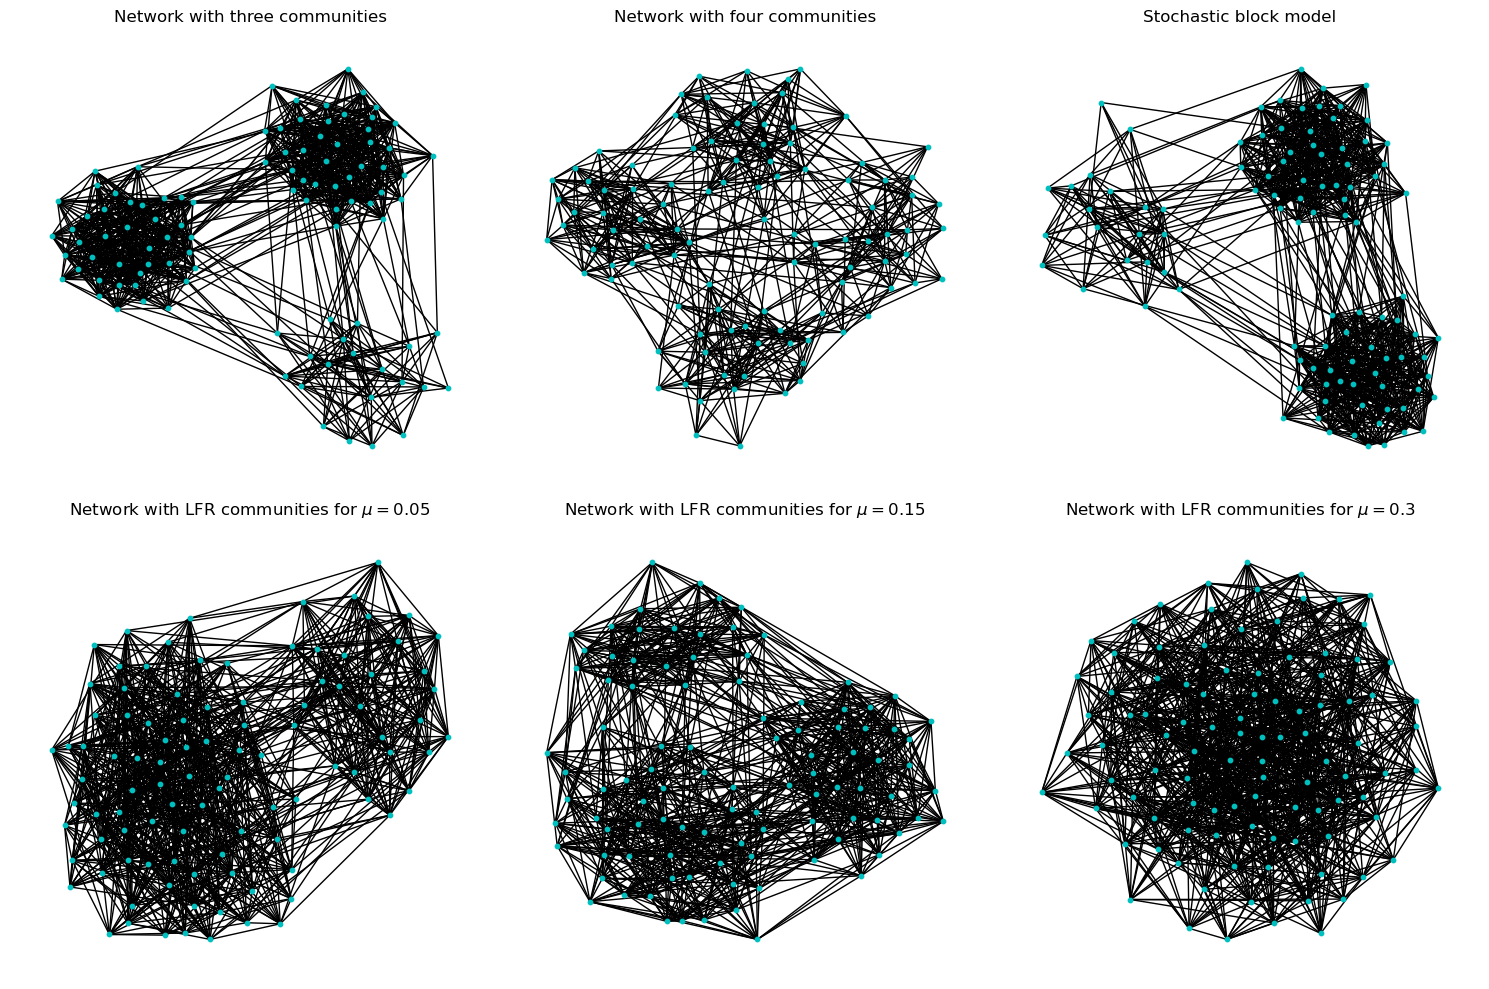

In [ ]:
# Network with communities
G_1 = network_with_communities(partition_sizes, p_in, p_out, seed)
vlbd_1, mvr_1, lambda_c1 = calculate_sync(G_1)

# Network with communities
G_2 = g_k_graph(16, 3)
vlbd_2, mvr_2, lambda_c2 = calculate_sync(G_2)

# Stochastic block model
G_3 = stochastic_block_model_graph(partition_sizes, p_in, p_out, seed)
vlbd_3, mvr_3, lambda_c3 = calculate_sync(G_3)

# Network with LFR communities for $\mu=0.01$
G_4 = network_with_LFR_communities(N, tau1, tau2, 0.05, 1.5*kappa, minc, maxc)
vlbd_4, mvr_4, lambda_c4 = calculate_sync(G_4)

# Network with LFR communities for $\mu=0.05$
G_5 = network_with_LFR_communities(N, tau1, tau2, 0.15, 1.5*kappa, minc, maxc)
vlbd_5, mvr_5, lambda_c5 = calculate_sync(G_5)

# Network with LFR communities for $\mu=0.2$
G_6 = network_with_LFR_communities(N, tau1, tau2, 0.3, 1.5*kappa, minc, maxc)
vlbd_6, mvr_6, lambda_c6 = calculate_sync(G_6)


# Creation of the figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plotting the graphs
plot_network(G_1, ax=axes[0, 0])
axes[0, 0].set_title("Network with three communities")

plot_network(G_2, ax=axes[0, 1])
axes[0, 1].set_title("Network with four communities")

plot_network(G_3, ax=axes[0, 2])
axes[0, 2].set_title("Stochastic block model")

plot_network(G_4, ax=axes[1, 0])
axes[1, 0].set_title("Network with LFR communities for $\mu=0.05$")

plot_network(G_5, ax=axes[1, 1])
axes[1, 1].set_title("Network with LFR communities for $\mu=0.15$")

plot_network(G_6, ax=axes[1, 2])
axes[1, 2].set_title("Network with LFR communities for $\mu=0.3$")

# Adjusting the spacing between subplots
plt.tight_layout()

plt.savefig('networks_communit.eps', dpi=300)

# Display the plot
plt.show()

### Plotting network synchronization

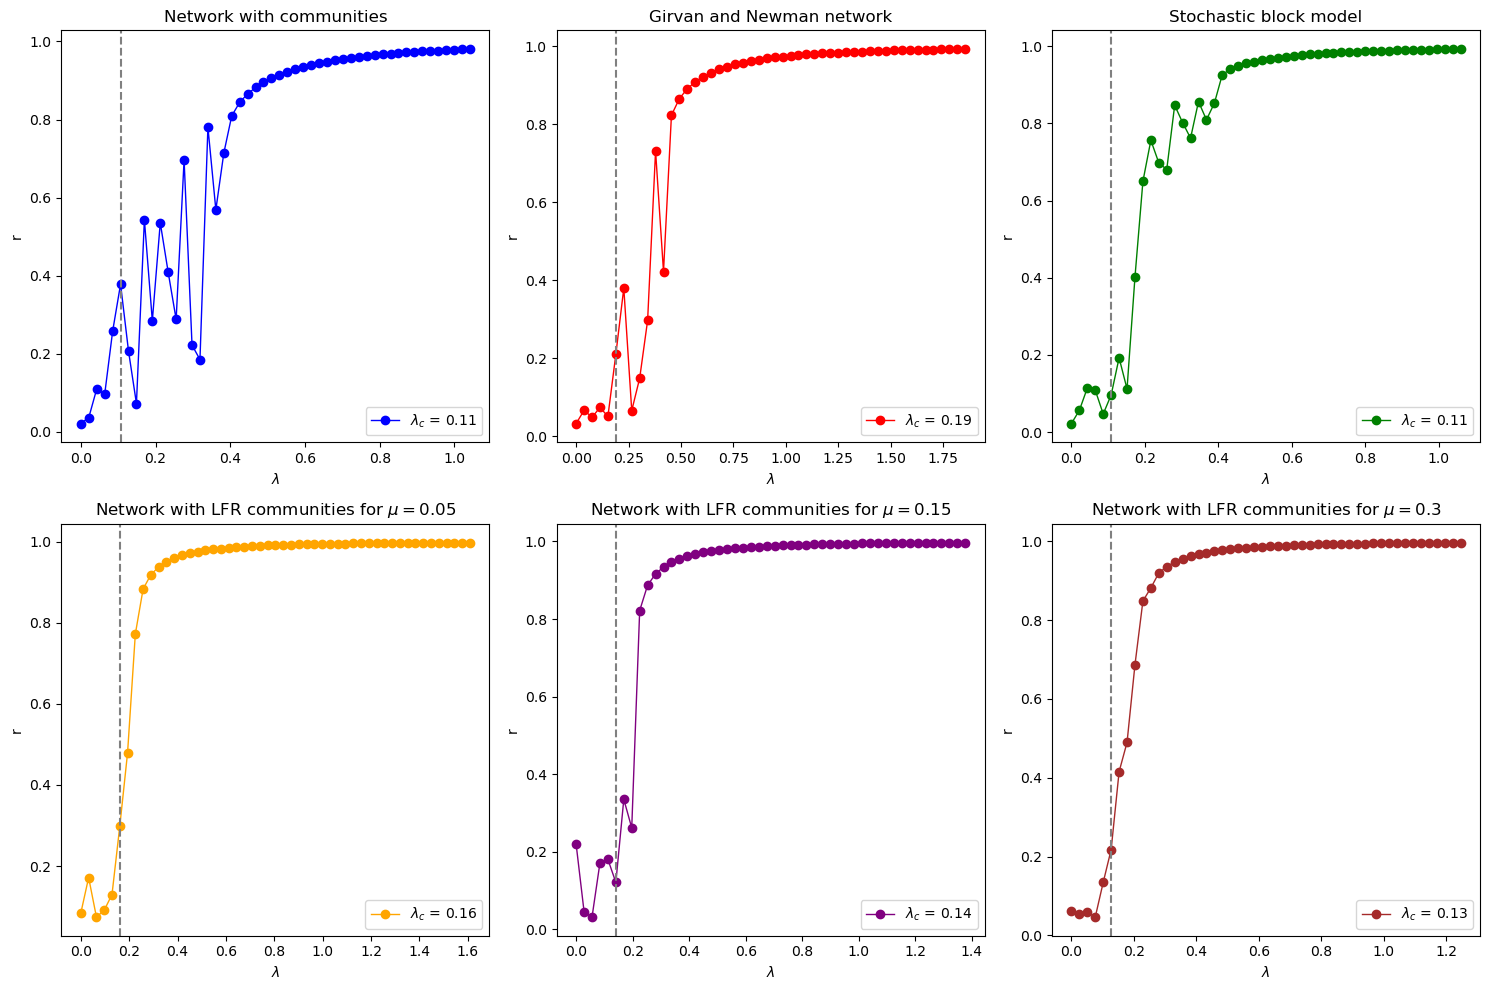

In [ ]:
plt.figure(figsize=(15, 10))

# First plot
plt.subplot(2, 3, 1)
plt.plot(vlbd_1, mvr_1, '-o', color='blue', linewidth=1, label=f'$\lambda_c$ = {lambda_c1:.2f}')
plt.axvline(x=lambda_c1, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Network with communities")
plt.legend()

# Second plot
plt.subplot(2, 3, 2)
plt.plot(vlbd_2, mvr_2, '-o', color='red', linewidth=1, label=f'$\lambda_c$ = {lambda_c2:.2f}')
plt.axvline(x=lambda_c2, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Girvan and Newman network")
plt.legend()

# Third plot
plt.subplot(2, 3, 3)
plt.plot(vlbd_3, mvr_3, '-o', color='green', linewidth=1, label=f'$\lambda_c$ = {lambda_c3:.2f}')
plt.axvline(x=lambda_c3, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Stochastic block model")
plt.legend()

# Fourth plot
plt.subplot(2, 3, 4)
plt.plot(vlbd_4, mvr_4, '-o', color='orange', linewidth=1, label=f'$\lambda_c$ = {lambda_c4:.2f}')
plt.axvline(x=lambda_c4, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Network with LFR communities for $\mu=0.05$")
plt.legend()

# Fifth plot
plt.subplot(2, 3, 5)
plt.plot(vlbd_5, mvr_5, '-o', color='purple', linewidth=1, label=f'$\lambda_c$ = {lambda_c5:.2f}')
plt.axvline(x=lambda_c5, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Network with LFR communities for $\mu=0.15$")
plt.legend()

# Sixth plot
plt.subplot(2, 3, 6)
plt.plot(vlbd_6, mvr_6, '-o', color='brown', linewidth=1, label=f'$\lambda_c$ = {lambda_c6:.2f}')
plt.axvline(x=lambda_c6, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Network with LFR communities for $\mu=0.3$")
plt.legend()

plt.tight_layout()
plt.show()


### All network synchronizations with community structures

Given the same creation conditions, networks with community structures tend to synchronize at similar critical $\lambda$ values. This occurs due to a combination of strong internal synchronization within communities and the propagation of synchronization between them. The hierarchy and homogeneity of community structures reduce the complexity of global synchronization, allowing it to occur at a consistent $\lambda$ in different similar networks. In the context of the Kuramoto model, which describes the synchronization of coupled oscillators, the presence of communities in the network facilitates synchronization, as oscillators within each community tend to synchronize first, promoting global synchronization as $\lambda$ increases.


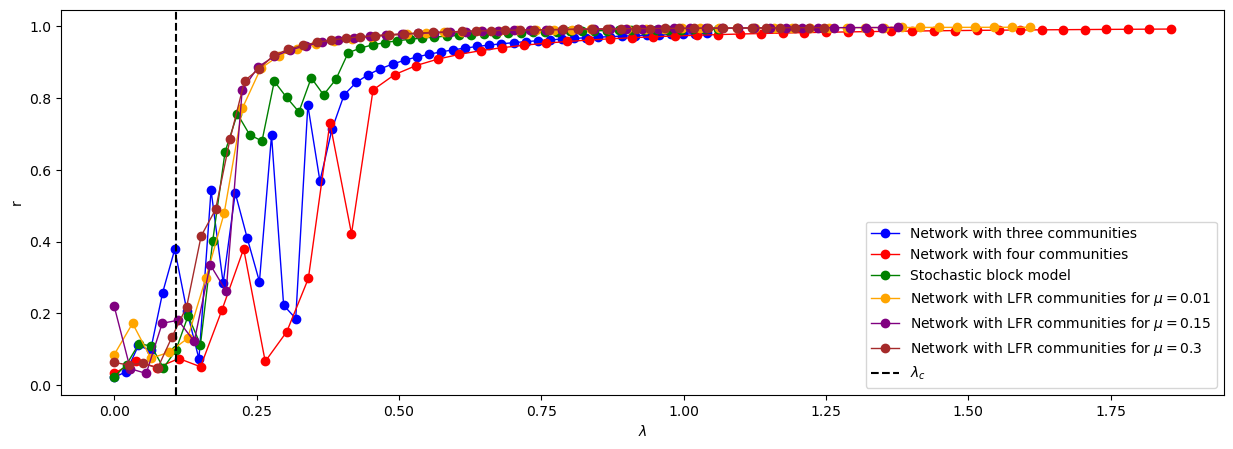

In [ ]:
# Show the results
plt.figure(figsize=(15,5))

# Plotting data
plt.plot(vlbd_1, mvr_1, '-o', color='blue', linewidth=1, label='Network with three communities')
plt.plot(vlbd_2, mvr_2, '-o', color='red', linewidth=1, label='Network with four communities')
plt.plot(vlbd_3, mvr_3, '-o', color='green', linewidth=1, label='Stochastic block model')
plt.plot(vlbd_4, mvr_4, '-o', color='orange', linewidth=1, label='Network with LFR communities for $\mu=0.01$')
plt.plot(vlbd_5, mvr_5, '-o', color='purple', linewidth=1, label='Network with LFR communities for $\mu=0.15$')
plt.plot(vlbd_6, mvr_6, '-o', color='brown', linewidth=1, label='Network with LFR communities for $\mu=0.3$')

# Adding vertical line
plt.axvline(x=lambda_c3, color='black', linestyle='--', label='$\lambda_c$')

# Labels and legend
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.legend()

# Save and show the plot
plt.savefig('networks_communit_syncro.png', format='png', dpi=300)
plt.show()



# Parameter $\mu$ in LFR network

The parameter $\mu$ in the LFR (Lancichinetti-Fortunato-Radicchi) network plays a crucial role in determining the community structure within the generated network. Specifically, $\mu$ controls the fraction of edges of a node that connect to nodes outside its own community compared to those connecting within its own community.

## Some properties of parameter $\mu$:

- **$\mu$ small or $\mu \approx 0$:** When $\mu$ is small, most edges of a node connect to other nodes within the same community. This results in well-defined and densely connected communities, with few connections between different communities.
- **$\mu$ intermediate:** For intermediate values of $\mu$, there is a balance between edges within the community and edges between communities. The communities are still visible but with more connections between different communities.
- **$\mu$ large or $\mu \approx 1$:** When $\mu$ is large, most edges of a node connect to nodes outside its community. This leads to a network structure where communities are less distinct and more interconnected, potentially even disappearing in extreme cases.

In practical terms, when generating an LFR network, varying $\mu$ allows simulating different levels of modularity and mixing between communities, which is useful for studying the robustness and dynamics of networks with varying degrees of community structure.

Given this context, a natural question about the properties of $\mu$ is whether there is any intrinsic relationship between $\mu$ and the parameter $\lambda$ in the Kuramoto model.



Let's generate some values of $\mu$ and calculate the value of $\lambda$, then visually extract any relationship between these two parameters.

---
**Note:** It's important to mention that because this part takes a long time, we had to lower the model parameter $\kappa$ to process the following code. Furthermore, reducing the parameter $\kappa$ allows us to better visualize how the parameter $\mu$ behaves in relation to the coupling $\lambda$.

In [ ]:
# Range of mu values
mu_values = np.linspace(0.01, 0.9, 30)
lambda_c_values = []
vlbd_values =[]
mvr_values =[]

for mu in mu_values:
    G = network_with_LFR_communities(N, tau1, tau2, mu, 5*1.5, minc, maxc, seed)
    vlbd, mvr, lambda_c = calculate_sync(G)
    lambda_c_values.append(lambda_c)
    vlbd_values.append(vlbd)
    mvr_values.append(mvr)

data = {
    'mu': mu_values,
    'lambda_c': lambda_c_values,
    'vlbd': vlbd_values,
    'mvr': mvr_values
}
df = pd.DataFrame(data)

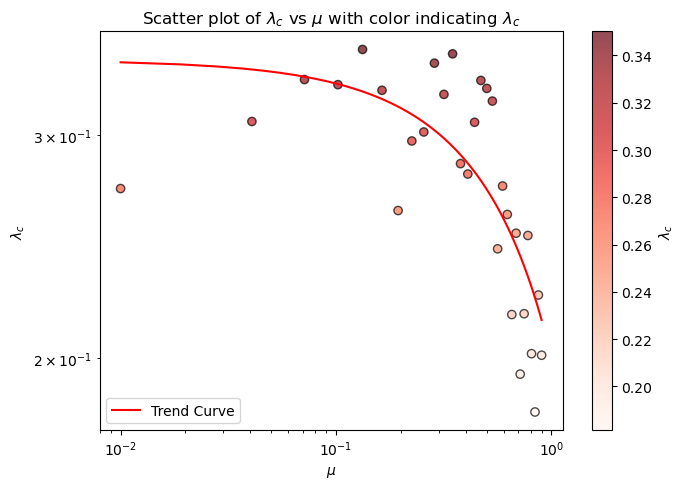

In [ ]:
# Data of DataFrame df
mu = df['mu']
lambda_c = df['lambda_c']

# Calculating the trend line (linear regression on logarithmic axes).
coefficients = np.polyfit(mu, lambda_c, 1)
poly = np.poly1d(coefficients)
x_values = np.linspace(min(mu), max(mu), 100)
y_values = poly(x_values)

# Plotting the scatter plot with the trend line
plt.figure(figsize=(7, 5))
plt.scatter(mu, lambda_c, c=lambda_c, cmap='Reds', edgecolor='k', alpha=0.7)
plt.colorbar(label='$\lambda_c$')
plt.xscale('log')
plt.yscale('log')
plt.plot(x_values, y_values, color='red', label='Trend Curve')
plt.xlabel("$\mu$")
plt.ylabel("$\lambda_c$")
plt.title("Scatter plot of $\lambda_c$ vs $\mu$ with color indicating $\lambda_c$")
plt.legend()
plt.tight_layout()
plt.show()

For simplicity of visualization, we transformed the axes to a logarithmic scale. Note that as $\mu$ increases, the coupling parameter $\lambda$ decreases.

### Generating networks without community structures

Now let's evaluate how network synchronization occurs in networks without community structures.

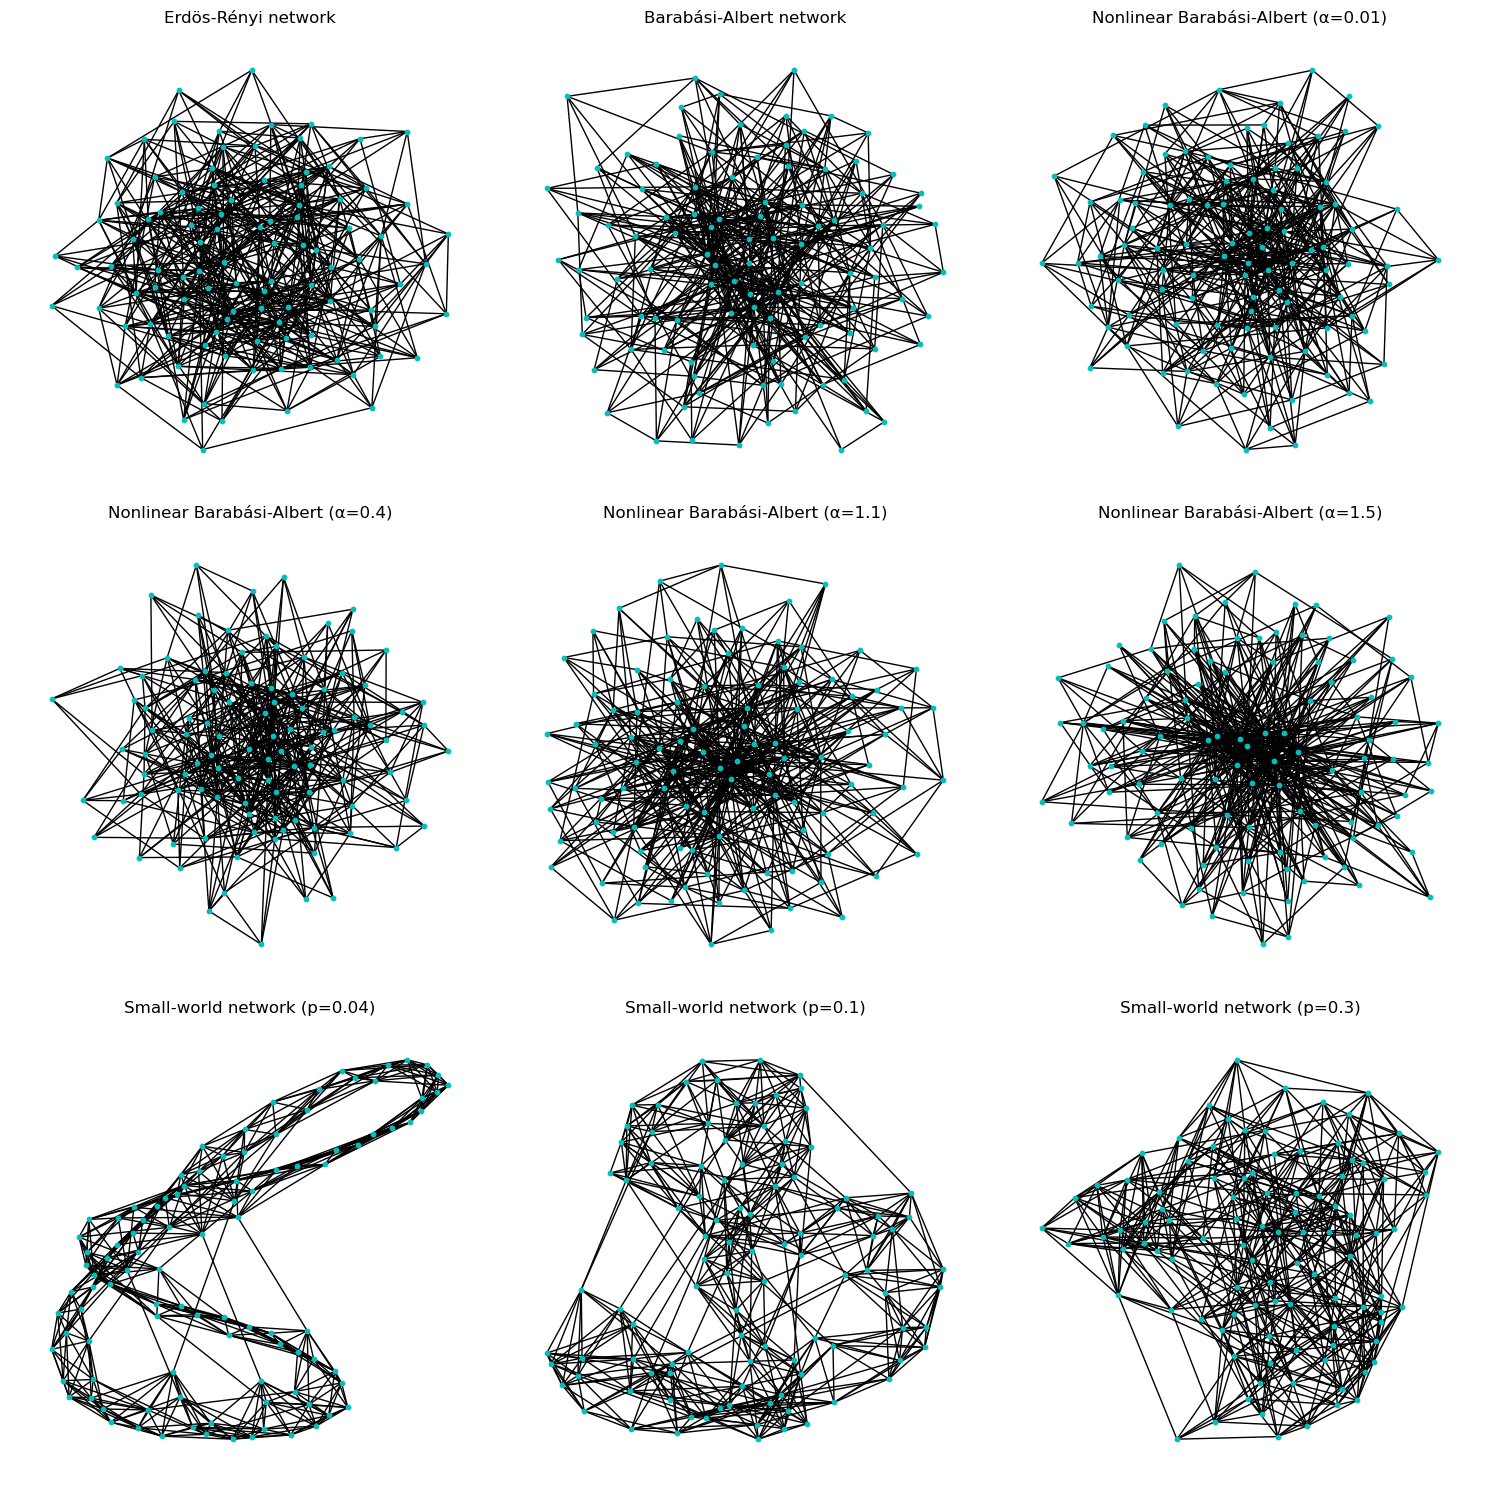

In [ ]:
# First network: Erdős-Rényi
G_7 = erdos_renyi_network(N, p)
vlbd_7, mvr_7, lambda_c7 = calculate_sync(G_7)

# Second network: Barabási-Albert
G_8 = barabasi_albert_network(N, m)
vlbd_8, mvr_8, lambda_c8 = calculate_sync(G_8)

# Third network: Nonlinear Barabási-Albert with α = 0.01
G_9 = nonlinear_barabasi_albert_graph(N, m, 0.01)
vlbd_9, mvr_9, lambda_c9 = calculate_sync(G_9)

# Fourth network: Nonlinear Barabási-Albert with α = 0.3
G_10 = nonlinear_barabasi_albert_graph(N, m, 0.3)
vlbd_10, mvr_10, lambda_c10 = calculate_sync(G_10)

# Fifth network: Nonlinear Barabási-Albert with α = 1.1
G_11 = nonlinear_barabasi_albert_graph(N, m, 1.1)
vlbd_11, mvr_11, lambda_c11 = calculate_sync(G_11)

# Sixth network: Nonlinear Barabási-Albert with α = 1.5
G_12 = nonlinear_barabasi_albert_graph(N, m, 1.5)
vlbd_12, mvr_12, lambda_c12 = calculate_sync(G_12)

# Seventh network: Small-world network with p = 0.04
G_13 = small_world_network(N, kappa, 0.04, seed)
vlbd_13, mvr_13, lambda_c13 = calculate_sync(G_13)

# Eighth network: Small-world network with p = 0.1
G_14 = small_world_network(N, kappa, 0.1, seed)
vlbd_14, mvr_14, lambda_c14 = calculate_sync(G_14)

# Ninth network: Small-world network with p = 0.3
G_15 = small_world_network(N, kappa, 0.3, seed)
vlbd_15, mvr_15, lambda_c15 = calculate_sync(G_15)


# Creating the figure and subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Plotting the networks
plot_network(G_7, ax=axes[0, 0])
axes[0, 0].set_title("Erdös-Rényi network")

plot_network(G_8, ax=axes[0, 1])
axes[0, 1].set_title("Barabási-Albert network")

plot_network(G_9, ax=axes[0, 2])
axes[0, 2].set_title("Nonlinear Barabási-Albert (α=0.01)")

plot_network(G_10, ax=axes[1, 0])
axes[1, 0].set_title("Nonlinear Barabási-Albert (α=0.4)")

plot_network(G_11, ax=axes[1, 1])
axes[1, 1].set_title("Nonlinear Barabási-Albert (α=1.1)")

plot_network(G_12, ax=axes[1, 2])
axes[1, 2].set_title("Nonlinear Barabási-Albert (α=1.5)")

plot_network(G_13, ax=axes[2, 0])
axes[2, 0].set_title("Small-world network (p=0.04)")

plot_network(G_14, ax=axes[2, 1])
axes[2, 1].set_title("Small-world network (p=0.1)")

plot_network(G_15, ax=axes[2, 2])
axes[2, 2].set_title("Small-world network (p=0.3)")

# Adjusting the spacing between subplots
plt.tight_layout()

plt.savefig('networks.eps', dpi=300)

# Display the plot
plt.show()

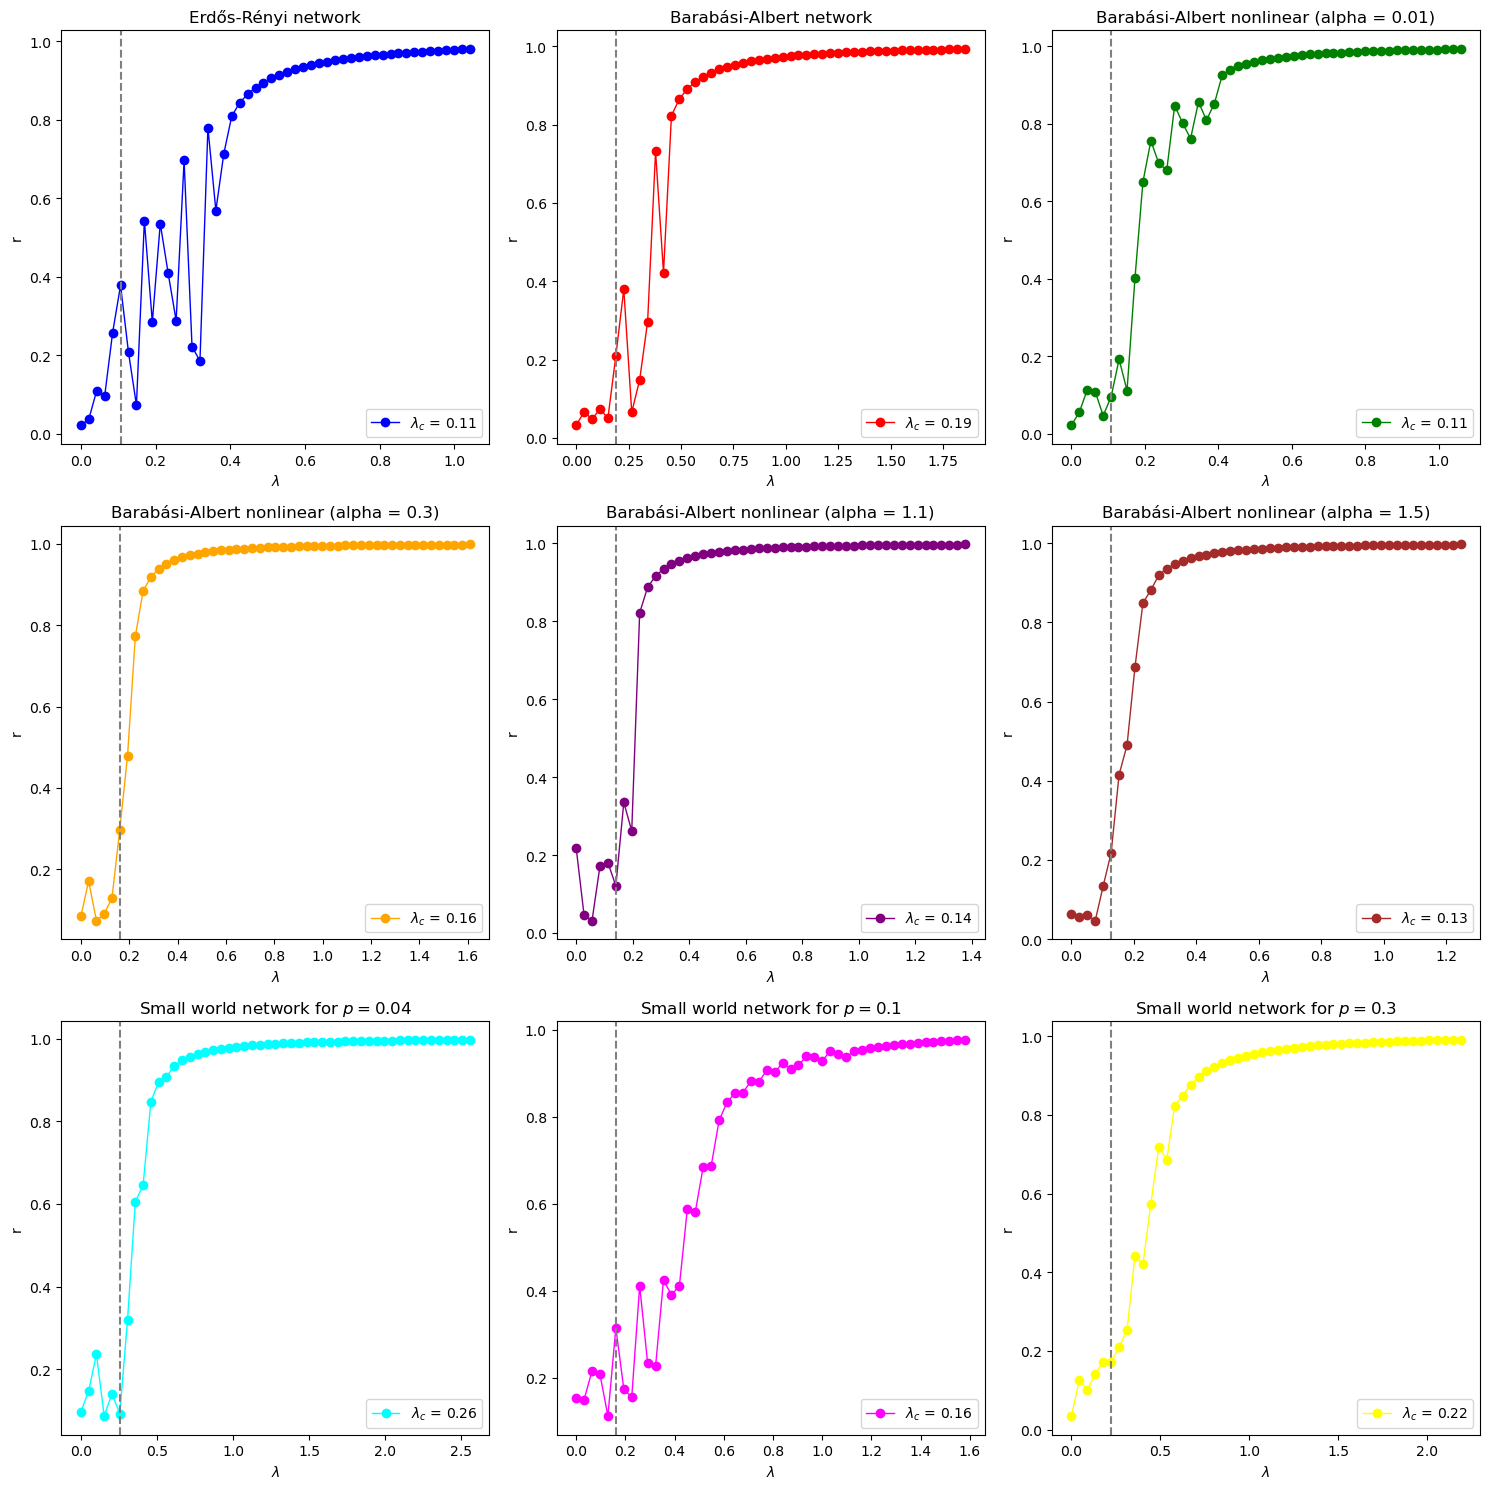

In [ ]:
plt.figure(figsize=(15, 15))

# First plot: Erdős-Rényi network
plt.subplot(3, 3, 1)
plt.plot(vlbd_1, mvr_1, '-o', color='blue', linewidth=1, label=f'$\lambda_c$ = {lambda_c1:.2f}')
plt.axvline(x=lambda_c1, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Erdős-Rényi network")
plt.legend()

# Second plot: Barabási-Albert network
plt.subplot(3, 3, 2)
plt.plot(vlbd_2, mvr_2, '-o', color='red', linewidth=1, label=f'$\lambda_c$ = {lambda_c2:.2f}')
plt.axvline(x=lambda_c2, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Barabási-Albert network")
plt.legend()

# Third plot: Barabási-Albert nonlinear (alpha = 0.01)
plt.subplot(3, 3, 3)
plt.plot(vlbd_3, mvr_3, '-o', color='green', linewidth=1, label=f'$\lambda_c$ = {lambda_c3:.2f}')
plt.axvline(x=lambda_c3, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Barabási-Albert nonlinear (alpha = 0.01)")
plt.legend()

# Fourth plot: Barabási-Albert nonlinear (alpha = 0.3)
plt.subplot(3, 3, 4)
plt.plot(vlbd_4, mvr_4, '-o', color='orange', linewidth=1, label=f'$\lambda_c$ = {lambda_c4:.2f}')
plt.axvline(x=lambda_c4, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Barabási-Albert nonlinear (alpha = 0.3)")
plt.legend()

# Fifth plot: Barabási-Albert nonlinear (alpha = 1.1)
plt.subplot(3, 3, 5)
plt.plot(vlbd_5, mvr_5, '-o', color='purple', linewidth=1, label=f'$\lambda_c$ = {lambda_c5:.2f}')
plt.axvline(x=lambda_c5, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Barabási-Albert nonlinear (alpha = 1.1)")
plt.legend()

# Sixth plot: Barabási-Albert nonlinear (alpha = 1.5)
plt.subplot(3, 3, 6)
plt.plot(vlbd_6, mvr_6, '-o', color='brown', linewidth=1, label=f'$\lambda_c$ = {lambda_c6:.2f}')
plt.axvline(x=lambda_c6, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Barabási-Albert nonlinear (alpha = 1.5)")
plt.legend()

# Seventh plot: Small world network for p = 0.04
plt.subplot(3, 3, 7)
plt.plot(vlbd_7, mvr_7, '-o', color='cyan', linewidth=1, label=f'$\lambda_c$ = {lambda_c7:.2f}')
plt.axvline(x=lambda_c7, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Small world network for $p=0.04$")
plt.legend()

# Eighth plot: Small world network for p = 0.1
plt.subplot(3, 3, 8)
plt.plot(vlbd_8, mvr_8, '-o', color='magenta', linewidth=1, label=f'$\lambda_c$ = {lambda_c8:.2f}')
plt.axvline(x=lambda_c8, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Small world network for $p=0.1$")
plt.legend()

# Ninth plot: Small world network for p = 0.3
plt.subplot(3, 3, 9)
plt.plot(vlbd_9, mvr_9, '-o', color='yellow', linewidth=1, label=f'$\lambda_c$ = {lambda_c9:.2f}')
plt.axvline(x=lambda_c9, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Small world network for $p=0.3$")
plt.legend()

plt.tight_layout()
plt.show()


### Synchronization in Networks without Community Structures

Given the same creation conditions, networks without community structures tend to synchronize at critical values of \(\lambda\) similar to those of networks with community structures. However, synchronization in networks without community structures occurs somewhat more slowly. This difference is due to the network topology, which directly influences the dynamics of synchronization.

It is worth noting that the presence of central hubs in Barabási-Albert networks facilitates the propagation of information across the network and, consequently, rapid synchronization. In Barabási-Albert networks, also known as scale-free networks, a few highly connected nodes (hubs) serve as focal points for the dissemination of synchronization. These hubs accelerate global synchronization by reducing the average path length between nodes, allowing information to spread more quickly across the network.


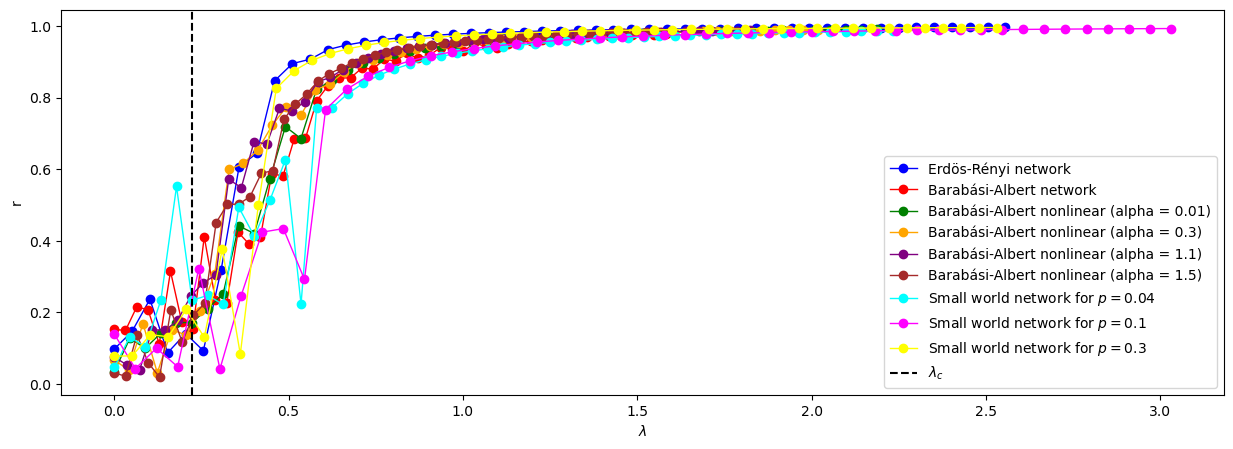

In [ ]:
# Show the results
plt.figure(figsize=(15, 5))

# Plotting data
plt.plot(vlbd_7, mvr_7, '-o', color='blue', linewidth=1, label='Erdös-Rényi network')
plt.plot(vlbd_8, mvr_8, '-o', color='red', linewidth=1, label='Barabási-Albert network')
plt.plot(vlbd_9, mvr_9, '-o', color='green', linewidth=1, label='Barabási-Albert nonlinear (alpha = 0.01)')
plt.plot(vlbd_10, mvr_10, '-o', color='orange', linewidth=1, label='Barabási-Albert nonlinear (alpha = 0.3)')
plt.plot(vlbd_11, mvr_11, '-o', color='purple', linewidth=1, label='Barabási-Albert nonlinear (alpha = 1.1)')
plt.plot(vlbd_12, mvr_12, '-o', color='brown', linewidth=1, label='Barabási-Albert nonlinear (alpha = 1.5)')
plt.plot(vlbd_13, mvr_13, '-o', color='cyan', linewidth=1, label='Small world network for $p=0.04$')
plt.plot(vlbd_14, mvr_14, '-o', color='magenta', linewidth=1, label='Small world network for $p=0.1$')
plt.plot(vlbd_15, mvr_15, '-o', color='yellow', linewidth=1, label='Small world network for $p=0.3$')

# Adding vertical line
plt.axvline(x=lambda_c9, color='black', linestyle='--', label='$\lambda_c$')

# Labels and legend
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.legend()

# Save and show the plot
plt.savefig('networks_syncro.png', format='png', dpi=300)
plt.show()


### Parameter $p$ in the Watts-Strogatz model (small-world)

Similarly to the analysis conducted for the LFR network, we will now perform a similar examination for the Watts-Strogatz network model. Specifically, we will investigate how variations in the parameter $p$ affect the coupling factor $\lambda$.

We will generate several values of $p$ and analyze whether there is any relationship between these values and the coupling factor $\lambda$.

---
**Note:** It's important to mention that because this part takes a long time, we had to lower the model parameter $\kappa$ to process the following code. Furthermore, reducing the parameter $\kappa$ allows us to better visualize how the parameter $p$ behaves in relation to the coupling $\lambda$.

In [ ]:
# Range of p values
p_values = np.linspace(0.01, 0.9, 30)
lambda_c_values = []
vlbd_values =[]
mvr_values =[]

for p in p_values:
    G = small_world_network(N, 5*1.5, p, seed)
    vlbd, mvr, lambda_c = calculate_sync(G)
    lambda_c_values.append(lambda_c)
    vlbd_values.append(vlbd)
    mvr_values.append(mvr)

data = {
    'p': p_values,
    'lambda_c': lambda_c_values,
    'vlbd': vlbd_values,
    'mvr': mvr_values
}
df = pd.DataFrame(data)

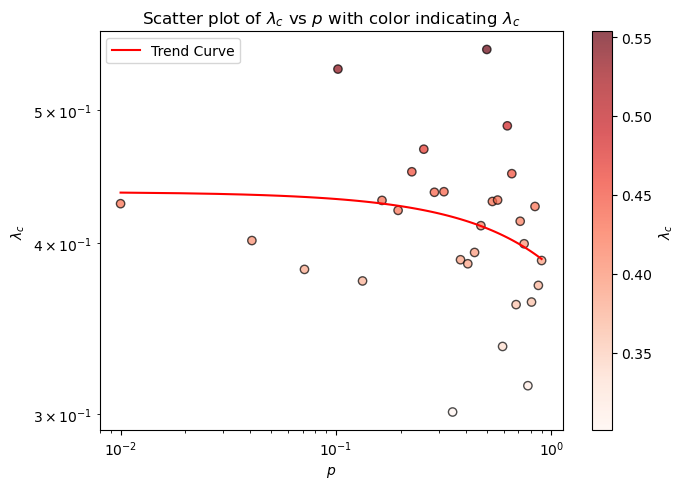

In [ ]:
# Data of DataFrame df
p_values = df['p']
lambda_c = df['lambda_c']

# Calculating the trend line (linear regression on logarithmic axes)
coefficients = np.polyfit(p_values, lambda_c, 1)
poly = np.poly1d(coefficients)
x_values = np.linspace(min(p_values), max(p_values), 100)
y_values = poly(x_values)

# Plotting the scatter plot with the trend line
plt.figure(figsize=(7, 5))
plt.scatter(p_values, lambda_c, c=lambda_c, cmap='Reds', edgecolor='k', alpha=0.7)
plt.colorbar(label='$\lambda_c$')
plt.xscale('log')
plt.yscale('log')
plt.plot(x_values, y_values, color='red', label='Trend Curve')
plt.xlabel("$p$")
plt.ylabel("$\lambda_c$")
plt.title("Scatter plot of $\lambda_c$ vs $p$ with color indicating $\lambda_c$")
plt.legend()
plt.tight_layout()
plt.show()

For simplicity of visualization, we transformed the axes to a logarithmic scale. Note that as $p$ increases, the coupling parameter $\lambda$ decreases

### Synchronization of Networks with Community Structure vs. Complex Networks without Community Structure


Synchronization in networks with community structures, where nodes are strongly connected, tends to occur for relatively low values of $\lambda$ (the coupling strength). This happens because nodes within a community are more strongly coupled to each other, allowing them to align their oscillation phases more easily. The strength of intra-community connections facilitates communication and phase alignment, leading to rapid local synchronization. This is especially evident in networks where communities are densely connected.

On the other hand, in the Kuramoto model, networks without community structures tend to synchronize more slowly due to the uniform distribution of connections, the lack of strongly connected subgroups, the absence of a modular structure, and less efficient communication. These characteristics hinder the rapid alignment of oscillator phases, requiring stronger coupling and more time to achieve global synchronization.
